# TDT17 Mini-Project

## 1.0 Project Overview and Objectives

## 2.0 Setting up the enviroment

Beginning to exploit our dataset we will import the necessary modules.

In [36]:
import os
import glob
import shutil
from xml.dom import minidom
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from PIL import Image, ImageDraw
import json
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm.notebook import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import zipfile


For the first phase of the project we will get to know our dataset. Right now each dataset from the six countries are in different folders. The folder hierachy can be seen below:

In [54]:
!tree -d "/cluster/work/salara/TDT17/data"

/cluster/work/salara/TDT17/data
├── China_Drone
│   └── train
│       ├── annotations
│       │   └── xmls
│       └── images
├── China_MotorBike
│   ├── test
│   │   └── images
│   └── train
│       ├── annotations
│       │   └── xmls
│       └── images
├── Czech
│   ├── test
│   │   └── images
│   └── train
│       ├── annotations
│       │   └── xmls
│       └── images
├── India
│   ├── test
│   │   └── images
│   └── train
│       ├── annotations
│       │   └── xmls
│       └── images
├── Japan
│   ├── test
│   │   └── images
│   └── train
│       ├── annotations
│       │   └── xmls
│       └── images
├── Norway
│   ├── test
│   │   └── images
│   └── train
│       ├── annotations
│       │   └── xmls
│       └── images
└── United_States
    ├── test
    │   └── images
    └── train
        ├── annotations
        │   └── xmls
        └── images

47 directories


## 3.0 Data Import and Preprocessing

One of the things I noticed is the different image sizes:
* China Drone ($512 \times 512$)
* China Motorbike ($512 \times 512$)
* Czech ($600 \times 600$)
* India ($720 \times 720$)
* Japan ($600 \times 600$)
* United States  ($640 \times 640$)
* Norway (Large difference in image sizes)

In [55]:

def data_count(dataset_path = "/cluster/work/salara/TDT17/data"):
    
    test_data = dict()
    train_data = dict()
    countries = []

    # Get all countries
    for file in os.listdir(dataset_path):
        d = os.path.join(dataset_path, file)
        if os.path.isdir(d):
            train_data[str(d[len(dataset_path) + 1:])] = 0
            test_data[str(d[len(dataset_path) + 1:])] = 0
            

    # using glob makes it easier to iterate through the folder
    dataset_path = Path(dataset_path)
    
    # Counter ffor train data
    for country in train_data:
        for image in dataset_path.glob(f'{country}/train/**/*.jpg'):
            train_data[country] += 1
            
    
            
    # Counter ffor test data
    dataset_path = Path(dataset_path)
    for country in train_data:
        for image in dataset_path.glob(f'{country}/test/**/*.jpg'):
            test_data[country] += 1
    
    
        

    return train_data, test_data



Text(0, 0.5, 'Number of images')

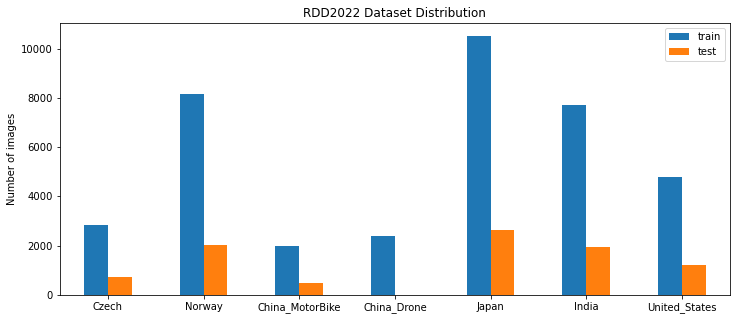

In [56]:
train_X, test_y = data_count()

df = pd.DataFrame({'train': list(train_X.values()),
                   'test': list(test_y.values())}, index=list(train_X.keys()))

ax = df.plot.bar(title="RDD2022 Dataset Distribution",rot=0, linewidth=10, figsize=(12,5))
ax.set_ylabel("Number of images")

### 3.1 PascalVOC to YOLO

Create folder for all the labels in the image

In [142]:
!mkdir /cluster/work/salara/TDT17/data/China_Drone/train/labels

!mkdir /cluster/work/salara/TDT17/data/China_MotorBike/train/labels
!mkdir /cluster/work/salara/TDT17/data/China_MotorBike/test/labels

!mkdir /cluster/work/salara/TDT17/data/Czech/train/labels
!mkdir /cluster/work/salara/TDT17/data/Czech/test/labels

!mkdir /cluster/work/salara/TDT17/data/India/train/labels
!mkdir /cluster/work/salara/TDT17/data/India/test/labels


!mkdir /cluster/work/salara/TDT17/data/Japan/train/labels
!mkdir /cluster/work/salara/TDT17/data/Japan/test/labels


!mkdir /cluster/work/salara/TDT17/data/Norway/train/labels
!mkdir /cluster/work/salara/TDT17/data/Norway/test/labels

!mkdir /cluster/work/salara/TDT17/data/United_States/train/labels
!mkdir /cluster/work/salara/TDT17/data/United_States/test/labels

mkdir: cannot create directory ‘/cluster/work/salara/TDT17/data/China_MotorBike/test/labels’: File exists
mkdir: cannot create directory ‘/cluster/work/salara/TDT17/data/Czech/test/labels’: File exists
mkdir: cannot create directory ‘/cluster/work/salara/TDT17/data/India/test/labels’: File exists
mkdir: cannot create directory ‘/cluster/work/salara/TDT17/data/Japan/test/labels’: File exists
mkdir: cannot create directory ‘/cluster/work/salara/TDT17/data/Norway/test/labels’: File exists
mkdir: cannot create directory ‘/cluster/work/salara/TDT17/data/United_States/test/labels’: File exists


Convert all xml files into txt files or YOLO format. We start with training data:

In [143]:
# Define direcotries
input_dir = "/cluster/work/salara/TDT17/data"
output_dir = "/cluster/work/salara/TDT17/data"



classes =  ['D00', 'D10', 'D40', 'D20']



# identify all the xml files in the annotations folder (input directory)
files = Path(input_dir).glob('**/**/*.xml')

# Counter
counter = 0


# Loop through all training files to convert


for country in list(train_X.keys()):
    for fil in Path(input_dir).glob(f'{country}/train/annotations/**/*.xml'):
        basename = os.path.basename(fil)    
        filename = os.path.splitext(basename)[0]
        
        # check if the label contains the corresponding image file
        if not glob.glob(f'{input_dir}/**/train/**/{filename}.jpg'):
            print(f"{filename} image does not exist!")
            continue

    
        result = []
        counter += 1

        # parse the content of the xml file
        tree = ET.parse(fil)
        root = tree.getroot()
        width = int(root.find("size").find("width").text)
        height = int(root.find("size").find("height").text)

        for obj in root.findall('object'):
            label = obj.find("name").text

            # check for new classes and append to list
            if label not in classes:
                break
            index = classes.index(label)
            pil_bbox = [int(float(x.text)) for x in obj.find("bndbox")]
            
            yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)

            # convert data to string
            bbox_string = " ".join([str(x) for x in yolo_bbox])
            result.append(f"{index} {bbox_string}")

        if result:
            # generate a YOLO format text file for each xml file
            with open(os.path.join(output_dir, f"{country}/train/labels/{filename}.txt"), "w", encoding="utf-8") as f:
                f.write("\n".join(result))


# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))
    print("Classes: ", classes)

print("Number of files converted ", counter)


Classes:  ['D00', 'D10', 'D40', 'D20']
Number of files converted  38385


### 3.2 Visualize data with new format

In [144]:
def yolo_to_xml_bbox(bbox, w, h, cls):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax, cls]


def draw_image(img, bboxes):
    draw = ImageDraw.Draw(img)
    for bbox in bboxes:
        draw.rectangle(bbox[0:4], outline="red", width=2)
        draw.text((bbox[2], bbox[1] - 10), bbox[-1], fill=(255,0,0,255) )

    display(img)


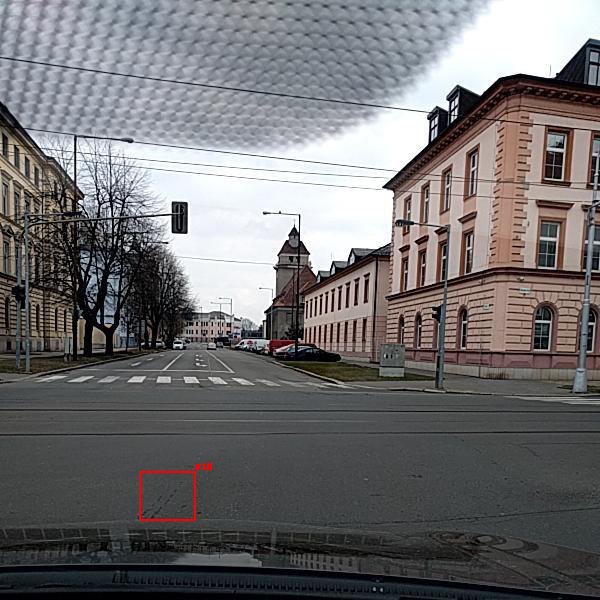

In [145]:
# Classes 
classes =  ['D00', 'D10', 'D40', 'D20']

# Generate random images for test
file_path_type = ["/cluster/work/salara/TDT17/data/**/train/labels/*.txt"]

# Get randome image from the entire dataset
labels = glob.glob(random.choice(file_path_type))
file_name = random.choice(labels)

# Get only file name
basename = os.path.basename(file_name)   
file_name = os.path.splitext(basename)[0]

# Get random image
image_filename = glob.glob(f"/cluster/work/salara/TDT17/data/**/train/images/{file_name}.jpg")

# Get label for corresponding image
label_filename = glob.glob(f"/cluster/work/salara/TDT17/data/**/train/labels/{file_name}.txt")
bboxes = []

# Open image
img = Image.open(image_filename[0])

with open(label_filename[0], 'r', encoding='utf8') as f:
    for line in f:
        data = line.strip().split(' ')
        #print(line[0])
        cls = classes[int(line[0])]
        bbox = [float(x) for x in data[1:]]
        bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height, cls))


draw_image(img, bboxes)



### 3.3 Number of Objects per Class in Folder

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Text(0.5, 1.0, 'Number of objects per class across all images.')

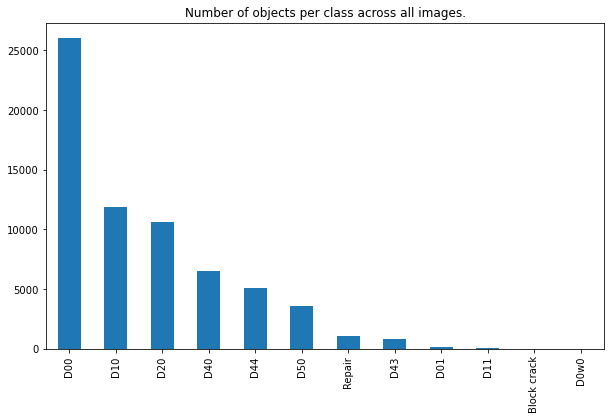

In [112]:
# get area of boundinx box
def _getArea(box):
    return (box[2] - box[0]) * (box[3] - box[1])


# Define relative path to folder containing the text files
files_folder = "/cluster/work/salara/TDT17/data/**/train/labels/"
files = []

# Create a dataframe list by using a list comprehension
files = [pd.read_csv(file, sep=' ', names =['class', 'x', 'y', 'w', 'h'] ) for file in glob.glob(os.path.join(files_folder ,"*.txt"))]


# Concatenate the list of DataFrames into one
files_df = pd.concat(files)

# Add area of bounding box
files_df['area'] = files_df['w'] * files_df['h']


# Get all classes
col_class = (files_df['class'].unique())

# Change the index to name of the class
for ind in col_class:
    files_df.loc[files_df["class"] == ind, "class"] = classes[ind]


# Plot all classes in the images
files_df['class'].value_counts().plot(kind='bar',figsize=(10,6))
plt.title('Number of objects per class across all images.')


### 3.4 Statistics of the BB

In [113]:
bbox_normal = files_df.groupby('class').agg([np.mean, np.std])

display(bbox_normal)

x                   y                   w            \
                 mean       std      mean       std      mean       std   
class                                                                     
Block crack  0.323893  0.285466  0.458008  0.295644  0.201172  0.031250   
D00          0.427166  0.219254  0.717814  0.176395  0.103657  0.093970   
D01          0.542198  0.214780  0.817194  0.081783  0.136321  0.073019   
D0w0         0.711806       NaN  0.800694       NaN  0.159722       NaN   
D10          0.459137  0.241809  0.700253  0.193418  0.289771  0.202751   
D11          0.529074  0.158193  0.854630  0.072757  0.450556  0.183408   
D20          0.506814  0.215772  0.744727  0.158935  0.389077  0.246704   
D40          0.489718  0.218784  0.722795  0.172805  0.126741  0.111612   
D43          0.525894  0.117213  0.710292  0.174275  0.703005  0.278597   
D44          0.513091  0.255789  0.733148  0.139146  0.262292  0.154500   
D50          0.511623  0.247633  0.664884  0.162944  0.106994  0.054369   
Repair       0.482126  0.250474  0.486710  0.268918  0.400060  0.260628   

                    h                area            
                 mean       std      mean       std  
class                                                
Block crack  0.259766  0.091422  0.050650  0.010692  
D00          0.190502  0.176987  0.026330  0.042357  
D01          0.165937  0.078249  0.025692  0.023578  
D0w0         0.240278       NaN  0.038378       NaN  
D10          0.056184  0.041951  0.021297  0.033628  
D11          0.078272  0.027978  0.035408  0.020829  
D20          0.264072  0.147624  0.121717  0.123856  
D40          0.078647  0.069214  0.015325  0.030580  
D43          0.197326  0.114158  0.157570  0.118695  
D44          0.247998  0.136082  0.075585  0.068668  
D50          0.038153  0.026838  0.005240  0.007511  
Repair       0.363358  0.258116  0.161281  0.180312

### 3.5 Distribution of Aspect Ratios

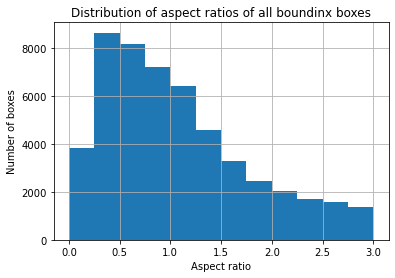

In [114]:
aspect_ratio = files_df['w'] / files_df['h']
plt.title("Distribution of aspect ratios of all boundinx boxes")
plt.ylabel("Number of boxes")
plt.xlabel("Aspect ratio")
aspect_ratio.hist(bins=12, range=(0,3))

### 3.6 Scatter Plots Area vs Aspect Ratio

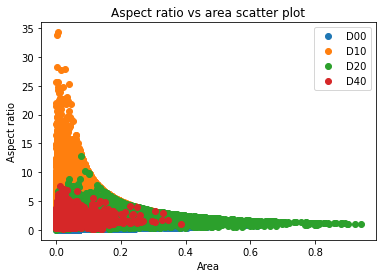

In [115]:


colormap = {
    'D00':'C0',
    'D10':'C1',
    'D20':'C2',
    'D40':'C3',
}

groups_plot = files_df.loc[((files_df['class'] == 'D00') | (files_df['class'] == 'D10') | (files_df['class'] == 'D20') | (files_df['class'] == 'D40') )].groupby('class')
display(groups_plot)

for name, group in groups_plot:
    aspect_ratio = group['w']/group['h']
    plt.plot(group['area'], aspect_ratio, marker="o", linestyle="", label=name, color=colormap[name])

plt.title("Aspect ratio vs area scatter plot")
plt.xlabel("Area")
plt.ylabel("Aspect ratio")
plt.legend()
plt.show()




## Yolov5

### Installation

In [ ]:
%cd /cluster/work/salara/TDT17/yolov5
!git clone https://github.com/ultralytics/yolov5.git "/cluster/work/salara/TDT17/yolov5"
%pip install -r requirements.txt

### Configurations

In [147]:
%cd /cluster/work/salara/TDT17/yolov5/data
!touch rdd2022.yaml

/cluster/work/salara/TDT17/yolov5/data


In [148]:
%%writefile rdd2022.yaml
path: /cluster/work/salara/TDT17/data  # dataset root dir
train: 
    - China_Drone/train/images/ 
    - China_MotorBike/train/images/
    - Czech/train/images/ 
    - India/train/images/  
    - Japan/train/images/ 
    - Norway/train/images/  
    - United_States/train/images/      
val: 
    - China_MotorBike/test/images/
    - Czech/test/images/ 
    - India/test/images/  
    - Japan/test/images/ 
    - Norway/test/images/  
    - United_States/test/images/ 
test: 

nc: 4
names: ['D00', 'D10', 'D40', 'D20']


Overwriting rdd2022.yaml


In [149]:
%cat /cluster/work/salara/TDT17/yolov5/data/rdd2022.yaml

path: /cluster/work/salara/TDT17/data  # dataset root dir
train: 
    - China_Drone/train/images/ 
    - China_MotorBike/train/images/
    - Czech/train/images/ 
    - India/train/images/  
    - Japan/train/images/ 
    - Norway/train/images/  
    - United_States/train/images/      
val: 
    - China_MotorBike/test/images/
    - Czech/test/images/ 
    - India/test/images/  
    - Japan/test/images/ 
    - Norway/test/images/  
    - United_States/test/images/ 
test: 

nc: 4
names: ['D00', 'D10', 'D40', 'D20']


### Image Augmentation

A [research paper](https://www.sciencedirect.com/science/article/pii/S1877050919315157) described different methods of data augmentation for classyfing Road Damage. The proposed method in the paper showed with experiments an increase in accuracy efficiently and effectively. It also overall imrpoved the mean Average Precision. Originally they used different data augmentation techniques dependent on the each class.

From the paper I will take some of the best performing tehnqiues that are not already implemented in Yolov5 framework. Note that the Yolov5 framework already have implemented a large variatey of image augmentation described in the paper, but I will try to add some additional image augmentation that are related to the weather from library albumentation to see if there are any improvements. 

* Random Rain
* Random Snow

The Yolov5 have integrated the library albumentation for augmentations `yolov5/utils/augmentations.py`, which executed additionally to ones in their hyperparameter in `yolov5/data/hyps/`. 


### Hyper parameters tuning


The hyperparaemeters are defined in `yolov5/data/hyps/`. For the dataset the default hyperparameters from this file is used `hyp.scratch-low.yaml`. We will try to train without modyfing this and later on try again to see if we can get any improvements. By adding a new file we can run the following command to use a new hyperparameter file. The following are the hyperparameters as default.

!cat /content/yolov5/data/hyps/hyp.scratch-low.yaml

!python train.py --batch 128 --weights yolov5m6.pt --data VOC.yaml --epochs 50 --img 512 --hyp hyp.VOC.yaml




### Run the code

In [151]:
# Train YOLOv5s on custom dataset 
%cd /cluster/work/salara/TDT17/yolov5/
!python train.py --img 600 --batch 16 --epochs 1 --data rdd2022.yaml --weights yolov5s.pt


/cluster/work/salara/TDT17/yolov5
/cluster/home/salara/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
train: weights=yolov5s.pt, cfg=, data=rdd2022.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=1, batch_size=16, imgsz=600, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-231-g0039870 Python-3.8.3 torch-1.